In [1]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from dgl import load_graphs
import sys
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.manifold import TSNE
import networkx as nx
sys.path.insert(1, '..')
from dgl_graphsage.utils import load_graph
from dgl_graphsage.utils import load_features

Using backend: pytorch


# Load Needed

In [2]:
with open('batch_recommendations.json') as woahs:
     woah = json.load(woahs)

In [3]:
%%time
# Loading Graph ~ 3min
feat_dir = "../../data/a13group1/460k_songset_features.csv"
scratch_pickle_dir = "../../data/a13group1/"
feat_data, uri_map = load_features(feat_dir, scratch_pickle_dir, False, playlist_num=100000)
graph_dir = ("../../data/a13group1/graph_460k.gpickle")
dgl_G, weights = load_graph(graph_dir, uri_map)

Loading feature data...
Feature data shape: torch.Size([461880, 13])
Loading graph data...
Graph Info:
 Name: G
Type: Graph
Number of nodes: 461880
Number of edges: 106486690
Average degree: 461.1011
CPU times: user 7min 29s, sys: 1min, total: 8min 30s
Wall time: 8min 14s


# Song Connectivity Within Recommendation

In [4]:
%%time
in_rec_accs = []
for i in range(len(woah)):
    res = list(combinations(woah[i]['recs'], 2))

    checks = []
    for pair in res:
        check = uri_map[pair[0]] in dgl_G.out_edges(uri_map[pair[1]])[1]
        checks.append(check)
        
    in_rec_accs.append(np.count_nonzero(checks) / len(checks))

CPU times: user 3h 46min 28s, sys: 1min 19s, total: 3h 47min 48s
Wall time: 29min 18s


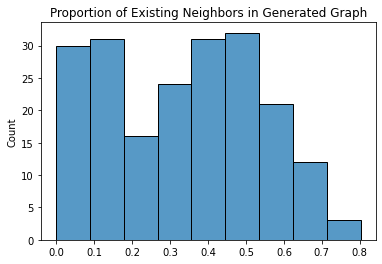

In [5]:
sns.histplot(in_rec_accs).set(title=f'Proportion of Existing Neighbors in Generated Graph')
plt.savefig('rec_connectivity.jpg')

# Feature Distribution

In [6]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

edafeats = pd.read_csv(os.path.join(os.path.expanduser('~'), 'GNN-Spotify-Recommender-Project/data/a13group1/songset_features_170k'))
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [7]:
edafeats.drop(columns=['id', 'uri'])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.904,0.813,4,0.241283,0,0.1210,0.031100,0.006970,0.0471,0.810,0.147007,-0.117592,4
1,0.774,0.838,5,0.932608,0,0.1140,0.024900,0.025000,0.2420,0.924,0.745093,-0.396133,4
2,0.664,0.758,2,0.354373,0,0.2100,0.002380,0.000000,0.0598,0.701,-0.744457,-0.027580,4
3,0.892,0.714,4,0.468764,0,0.1410,0.201000,0.000234,0.0521,0.817,-0.686176,0.283416,4
4,0.853,0.606,0,0.784854,1,0.0713,0.056100,0.000000,0.3130,0.654,-0.897559,-0.110287,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170084,0.551,0.822,11,0.260131,0,0.0614,0.001540,0.000000,0.2150,0.360,0.200831,0.261303,4
170085,0.480,0.761,6,0.777921,1,0.0367,0.120000,0.000000,0.2960,0.359,1.322800,1.290823,4
170086,0.402,0.767,11,0.325126,0,0.1710,0.000077,0.000003,0.3930,0.558,1.944497,-0.590001,4
170087,0.678,0.826,0,0.753223,0,0.0591,0.005240,0.000000,0.0951,0.706,0.641290,0.036080,4


In [8]:
def get_distribution(edafeats, uri_recs):
    numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
    categorical = ['key', 'mode', 'time_signature']

    feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

    for i in numerical:
        cur_feats = edafeats[edafeats['id'].isin(uri_recs)]

        var = np.var(cur_feats[i])
        feat_vars[i] = (var)

        avg = np.mean(cur_feats[i])
        feat_avgs[i] = (avg)

        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i] = difs

        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i] = ranges

    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i] = highest

    feat_avgs.pop('key')
    feat_avgs.pop('mode')
    feat_avgs.pop('time_signature')

    feat_difs.pop('key')
    feat_difs.pop('mode')
    feat_difs.pop('time_signature')

    feat_ranges.pop('key')
    feat_ranges.pop('mode')
    feat_ranges.pop('time_signature')
    
    return feat_vars, feat_avgs, feat_difs, feat_ranges

In [9]:
%%time
# Get original playlists and recommendations for them.
# Saving sample of playlists
original_playlists = []
generated_playlists = []
for i in range(len(woah)):
    saved_seeds = woah[i]['seeds']
    saved_recs = woah[i]['recs']
    
    original_playlists.append(saved_seeds)
    generated_playlists.append(saved_recs)

CPU times: user 334 µs, sys: 3 µs, total: 337 µs
Wall time: 350 µs


In [15]:
%%time
# Will get the variances from originals and generated.
# Saves the differences between the variances for each playlist/generated playlist
size = len(original_playlists)
differences_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': []}
differences_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': []}
differences_feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': []}
differences_range = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': []}
for i in range(size):
    feat_vars_og, feat_avgs_og, feat_difs_og, feat_ranges_og = get_distribution(edafeats, original_playlists[i])
    feat_vars_gen, feat_avgs_gen, feat_difs_gen, feat_ranges_gen = get_distribution(edafeats, generated_playlists[i])
    
    for each in differences_vars.keys():
        differences_vars[each].append(np.abs(feat_vars_og[each] - feat_vars_gen[each]))
        differences_avgs[each].append(np.abs(feat_avgs_og[each] - feat_avgs_gen[each]))
        differences_feat_difs[each].append(np.abs(feat_difs_og[each] - feat_difs_gen[each]))
        differences_range[each].append(np.abs(feat_ranges_og[each] - feat_ranges_gen[each]))

CPU times: user 25 s, sys: 104 ms, total: 25.1 s
Wall time: 25.1 s


In [67]:
# Gets the average difference in variance for each feature
avg_differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': []}
for i in avg_differences.keys():
    avg_differences[i].append(np.mean(np.array(differences_vars[i])))
    avg_differences[i].append(np.mean(np.array(differences_avgs[i])))
    avg_differences[i].append(np.mean(pd.Series(differences_feat_difs[i]).dropna()))
    avg_differences[i].append(np.mean(np.array(differences_range[i])))

[0.36123076923076924, 0.04767025862068969, 0.05002111872146117, 0.0047499999999999765, 0.00040450563203997536, 0.0022500000000000298, 0.0697122641509434, 0.09448936170212763, 0.03640404040404041, 0.003093406593406567, 0.008388888888888918, 0.10788888888888881, 0.012237222757955607, 0.04147758620689648, 0.13861666666666672, 0.21949999999999997, 0.03240934065934073, 0.0686459369817579, 0.1350314285714285, 0.01621060275962241, 0.029540485829959495, 0.012489326765188935, 0.04277894736842103, 0.025475761475761527, 0.07714583333333341, 0.05002685421994889, 0.0076938735564689165, 0.06046153846153844, 0.03141414141414137, 0.11826666666666669, 0.10318421052631577, 0.01137499999999994, 0.05647692307692309, 0.0243618421052631, 0.11223376623376626, 0.06364864864864866, 0.02868589743589739, 0.16929699248120297, 0.347, 0.09337562189054721, 0.052074054054054075, 0.18538461538461537, 0.08652777777777776, 0.1683461538461538, 0.06065624999999991, 0.3134782608695652, 0.05812499999999998, 0.02252747252747

In [74]:
summary_of_differences = pd.DataFrame(avg_differences, index=['Avg. Difference in Variances', 'Avg. Difference in Averages', 'Avg. Difference Consecutive Difference Avg.', 'Avg. Difference in Ranges'])
summary_of_differences.transpose().to_csv('summary_of_differences.csv')

In [75]:
summary_of_differences.transpose()

,Avg. Difference in Variances,Avg. Difference in Averages,Avg. Difference Consecutive Difference Avg.,Avg. Difference in Ranges
danceability,0.014732,0.078192,0.074890,0.108447
energy,0.020829,0.104152,0.083423,0.132779
loudness,0.292311,0.360117,0.244781,0.913761
speechiness,0.010561,0.050712,0.082374,0.169303
acousticness,0.041992,0.152527,0.131845,0.170404
instrumentalness,0.018642,0.051785,0.057624,0.327682
liveness,0.014521,0.047200,0.067994,0.333911
valence,0.019403,0.105017,0.077813,0.153632
tempo,0.328140,0.293033,0.334630,1.080188
duration_ms,0.209659,0.221683,0.170648,1.249146


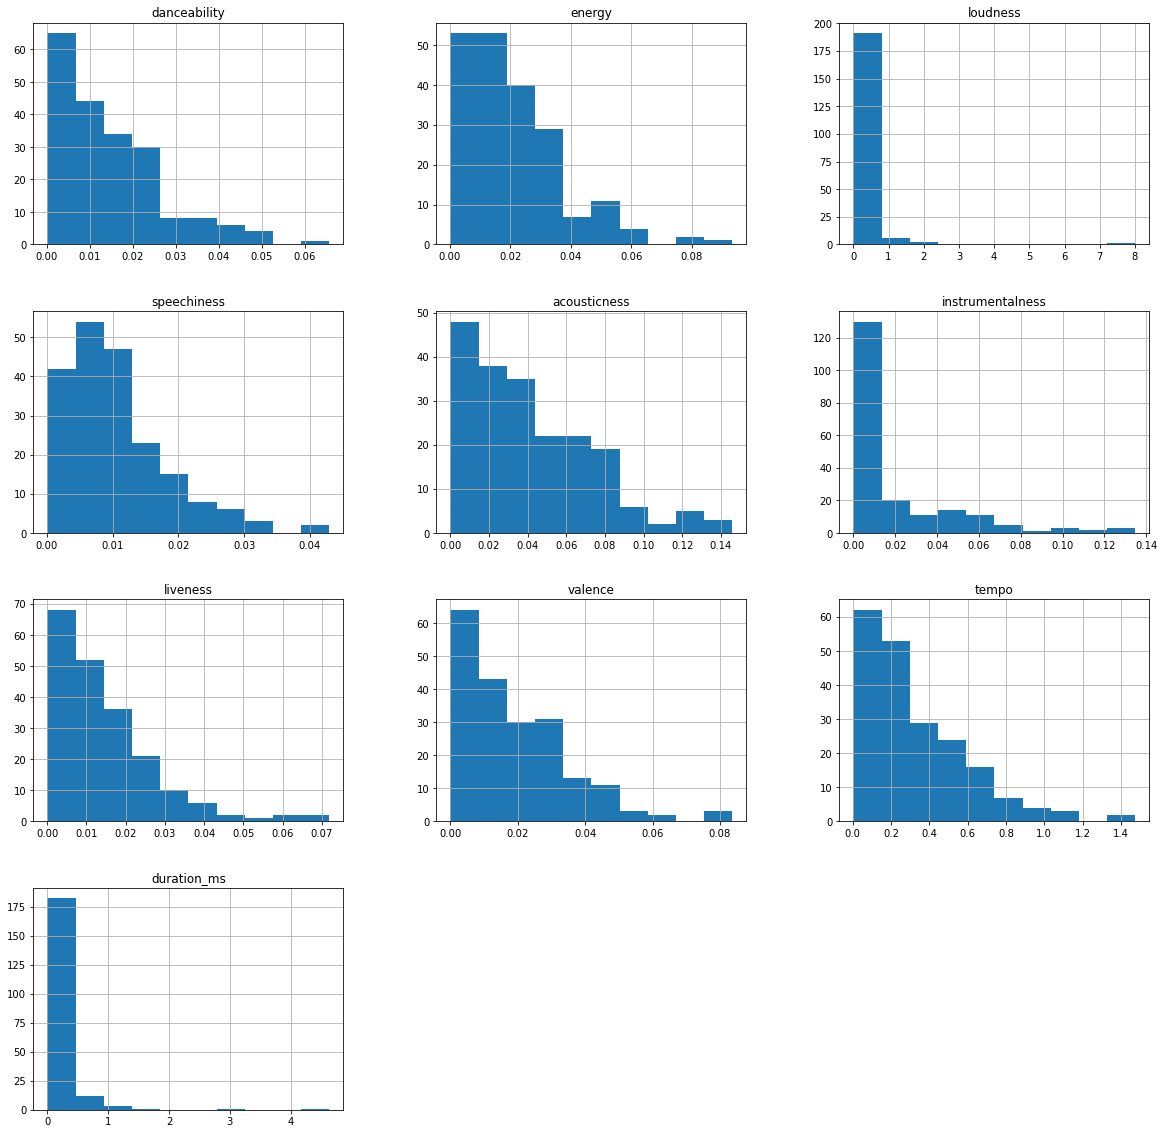

In [50]:
# Plots the differences for each variance
pd.DataFrame(differences_vars).hist(figsize=(20,20))
plt.savefig('var_differences.jpg')

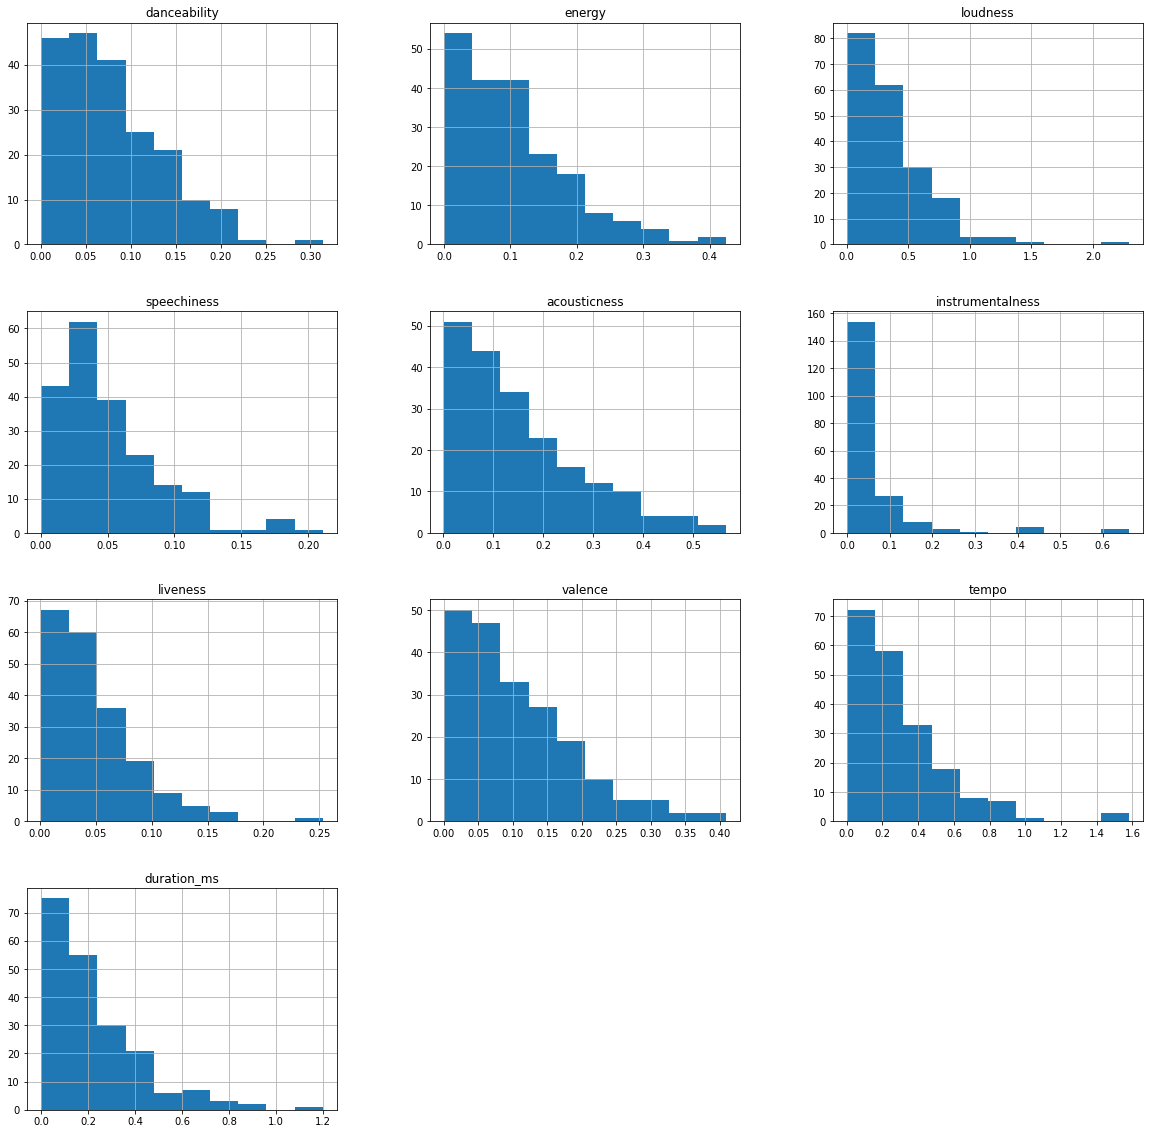

In [51]:
# Plots the differences for each average
pd.DataFrame(differences_avgs).hist(figsize=(20,20))
plt.savefig('avgs_differences.jpg')

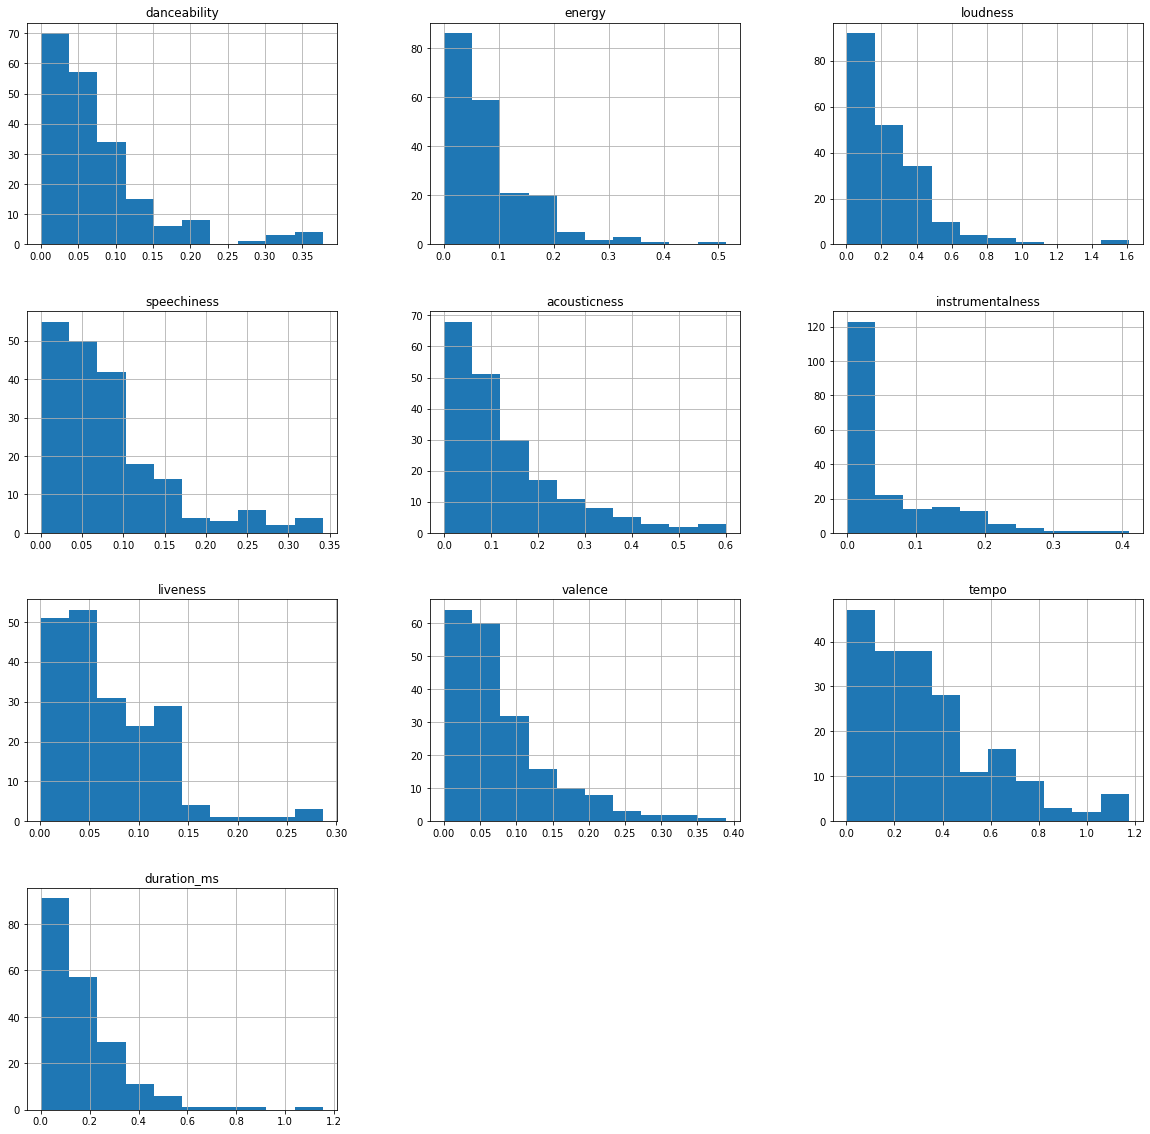

In [52]:
# Plots the differences for each feature_dif
pd.DataFrame(differences_feat_difs).hist(figsize=(20,20))
plt.savefig('feat_difs_differences.jpg')

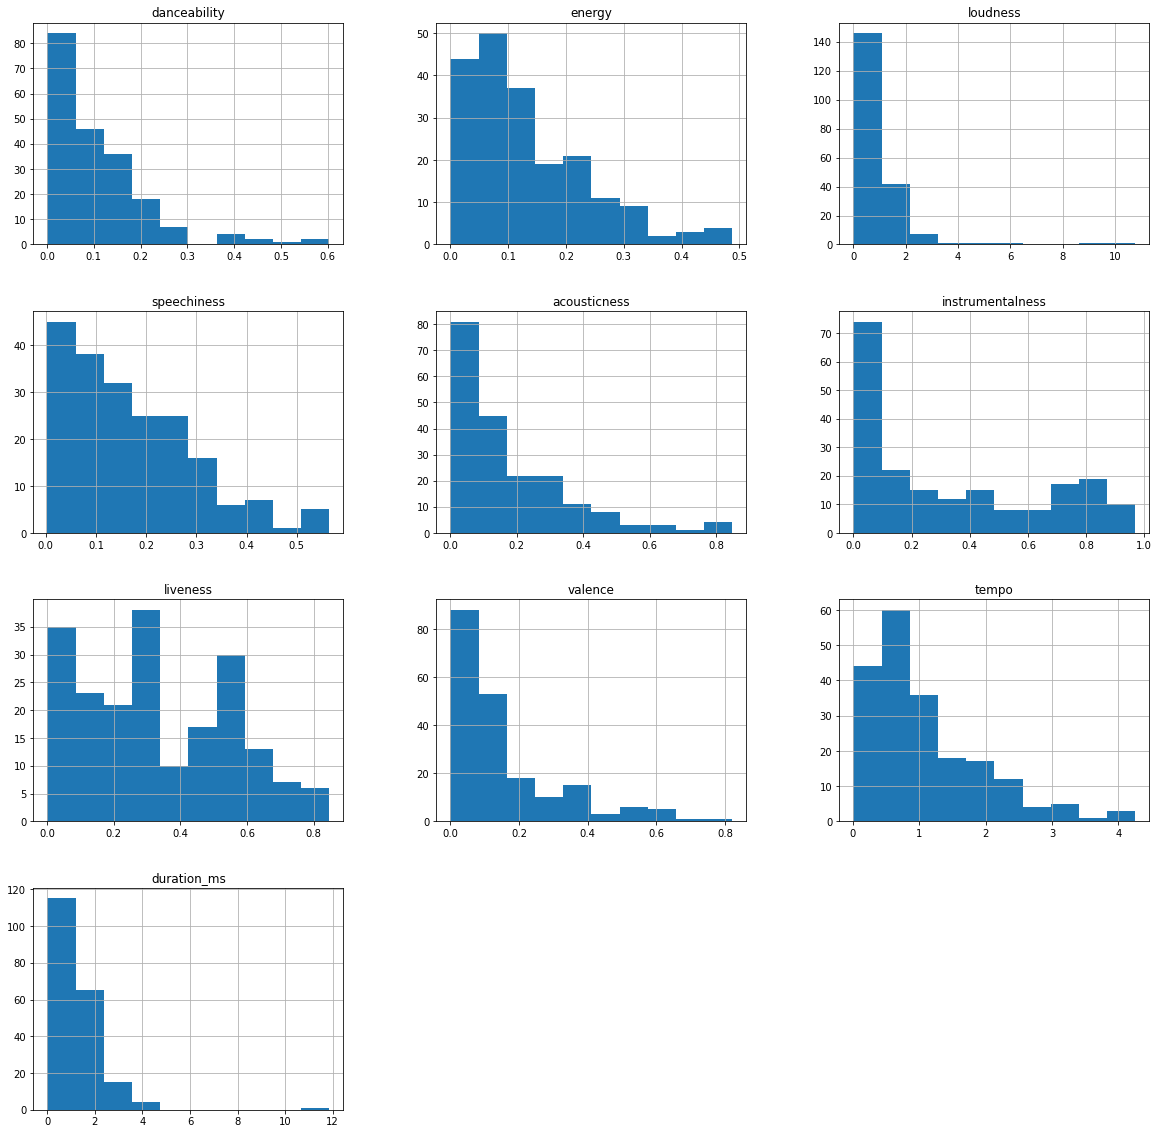

In [53]:
# Plots the differences for each range
pd.DataFrame(differences_range).hist(figsize=(20,20))
plt.savefig('range_differences.jpg')

# Embedding T-SNE
Will require training of the model

In [ ]:
# %%time
# # Loading Graph ~ 3min
# feat_dir = "../../data/a13group1/features/merged_features.csv"
# double_edge_dir = "../../data/a13group1/double_edges_170k.bin"
# feat_data, adj_list, dgl_G, uri_map = r.load_double_edge(feat_dir, double_edge_dir)

In [ ]:
# %%time
# # Training the Model. GPU ~ 00:00:40
# with open('../../config/model-params.json') as fh:
#             model_cfg = json.load(fh)
# model, pred = train(dgl_G, feat_data, adj_list, **model_cfg)

# # Put everything on CPU
# model = model.to('cpu')
# pred = pred.to('cpu')

In [ ]:
# # Create Embeddings
# z = model(dgl_G, feat_data)

# # Create Predictions
# # In the form of the strength of the connection between source, destination from dgl_G.edges()
# preds = pred(dgl_G, z)

### T-SNE

In [ ]:
# # Instantialte tsne, specify cosine metric
# tsne = TSNE(n_iter = 1000, metric = 'cosine', square_distances=True)

In [ ]:
# %%time
# ## WARNING -- AROUND 30 MINUTES TO COMPLETE
# embeddings2d = tsne.fit_transform(z.detach().numpy())

In [ ]:
# # Create DF
# embeddingsdf = pd.DataFrame()
# # Add game names
# embeddingsdf['id'] = edafeats['id']
# # Add x coordinate
# embeddingsdf['x'] = embeddings2d[:,0]
# # Add y coordinate
# embeddingsdf['y'] = embeddings2d[:,1]
# # Check
# embeddingsdf.head()


In [ ]:
# # Set figsize
# fig, ax = plt.subplots(figsize=(10,8))
# # Scatter points, set alpha low to make points translucent
# ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.01)
# plt.title('Scatter plot of Song Embeddings T-SNE')
# plt.savefig('embedding_tsne.jpg')
# plt.show()

# Measures for GraphSAGE Edge Prediction

In [77]:
with open('../../model_auc_prec_rec.txt') as train_measures:
    lines = train_measures.readlines()

In [78]:
lines

['Loading feature data...\n',
 'Feature data shape: torch.Size([461880, 13])\n',
 'Loading graph data...\n',
 'Graph Info:\n',
 ' Name: G\n',
 'Type: Graph\n',
 'Number of nodes: 461880\n',
 'Number of edges: 106486690\n',
 'Average degree: 461.1011\n',
 'Train pos edge: 168589834\n',
 'Validation pos edge: 306960\n',
 'Cuda enabled: True\n',
 '\n',
 'Training starts:\n',
 'Batches: 82\n',
 '-----\n',
 'In epoch 1 batch 1, loss: 0.7028547525405884\n',
 '-----\n',
 'In epoch 1 batch 2, loss: 0.703698456287384\n',
 '-----\n',
 'In epoch 1 batch 3, loss: 0.7009685039520264\n',
 '-----\n',
 'In epoch 1 batch 4, loss: 0.7043822407722473\n',
 '-----\n',
 'In epoch 1 batch 5, loss: 0.6993154883384705\n',
 '-----\n',
 'In epoch 1 batch 6, loss: 0.6953598260879517\n',
 '-----\n',
 'In epoch 1 batch 7, loss: 0.6980410814285278\n',
 '-----\n',
 'In epoch 1 batch 8, loss: 0.6933950185775757\n',
 '-----\n',
 'In epoch 1 batch 9, loss: 0.6928867697715759\n',
 '-----\n',
 'In epoch 1 batch 10, loss: 

In [76]:
pd.read_csv('../../model_auc_prec_rec.txt')

,Loading feature data...
Feature data shape: torch.Size([461880,13])
Loading graph data...,NaN
Graph Info:,NaN
Name: G,NaN
Type: Graph,NaN
...,...
1.0 0.89 0.77 0.82 306960,NaN
accuracy 0.78 467880,NaN
macro avg 0.77 0.79 0.77 467880,NaN
weighted avg 0.81 0.78 0.79 467880,NaN
